<h1 style="background-color:#a83299;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 20px 20px;font-family:cursive">Clustering text documents and Giving Recommendation Using K-means</h1>

### Pre-condition to Run ###
1. Ensure the data subfolder has four files:
    a. arxiv-metadata-ext-category.csv
    b. arxiv-metadata-ext-citation.csv
    c. arxiv-metadata-ext-taxonomy.csv
    d. arxiv-metadata-ext-version.csv
    e. arxiv-cs-papers-normalized.csv

    If those files do not exist, please run get_clean_text.py, line 62, the function `load_cs_papers("")` and line 65, `load_cs_papers("", "normalized", run_preprocessor=True)` to get those files ready.

2. If you want to re-train those word2vec, Kmeans models, etc., set variable `FAST_RUN_WITH_EXISTING_DATA` in the first cell to False. You could start to run the cells in sequence (skip the step 3). The whole model building process might take 1.2 hours.

3. If you want to use the existing trained models and other data, skip step 2.copy the data from this address: https://drive.google.com/drive/u/1/folders/1X-C6FK1IA-rYDuhZZmkFIQcZ43BpkQuE to your project folder. Ensure those files are put under <project folder>/model_data/. Keep `FAST_RUN_WITH_EXISTING_DATA` variable to True, and you could start to run the code in sequence.

In [29]:
# !pip install gensim
# !pip install wordcloud

In [30]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import kmeans_classify
pd.options.display.max_seq_items = 1000


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the pre-existing csv files into dataframes. Please ensure those .csv files exist in subfolder "data". If the .csv file does not exist, you need to run get_clean_text.py, line 62, `cs_papers = load_cs_papers("")` to download and process the abstract text.

In [31]:
# Prepare the dataframes 
df_citations = pd.read_csv("data/arxiv-metadata-ext-citation.csv",dtype={"id":object,"id_reference":object})
print("total records of df:citations:", df_citations.shape)

df_categories = pd.read_csv("data/arxiv-metadata-ext-category.csv",dtype={"id":object,"category_id":object})
print("total records of df:categories:", df_categories.shape)

df_taxonomy = pd.read_csv("data/arxiv-metadata-ext-taxonomy.csv")
print("total records of df_taxonomy:",df_taxonomy.shape)

df_versions = pd.read_csv("data/arxiv-metadata-ext-version.csv", dtype={'id': object})
print("total records of df_versions:",df_versions.shape)

'''
The three parameters will control
a. whether re-train the model or just load model from existing pickle file
b. whether using tf-idf or word2vec to vectorize words and docs
c. whether normalize word2vec result
Note: If using trained models, all the data is in https://drive.google.com/drive/u/1/folders/1SkgvFmTrqfRzHRMJZQcy557MsSpkdnGl, download the folder `model_data` and put it under project path.
'''
FAST_RUN_WITH_EXISTING_DATA = True         # choose fast running or not
NORMALIZE_VECTOR = True                    # choose using normalized vectors or not
USE_TFIDF = True

total records of df:citations: (6849633, 2)
total records of df:categories: (4173480, 2)
total records of df_taxonomy: (155, 6)
total records of df_versions: (2455227, 3)


Load the .csv file and concatenate with df_categories and df_taxonomy, so that the returned dataframe data_df contains more complete information about the paper. Please note:

a. A new field called "year" is added when you call the following function `kmeans_classify.concatenate_data`. The "year" field represents the published year of the paper. 
b. The abstract fields remove stop words of English in this function.

Exploratory Data Analysis: It is optional to call the function `view_top_category_paper_amount`. It is used to choose the top categories which contains the most amount of published paper. The result is shown in the diagram. The returned value records the list of all those top categories.

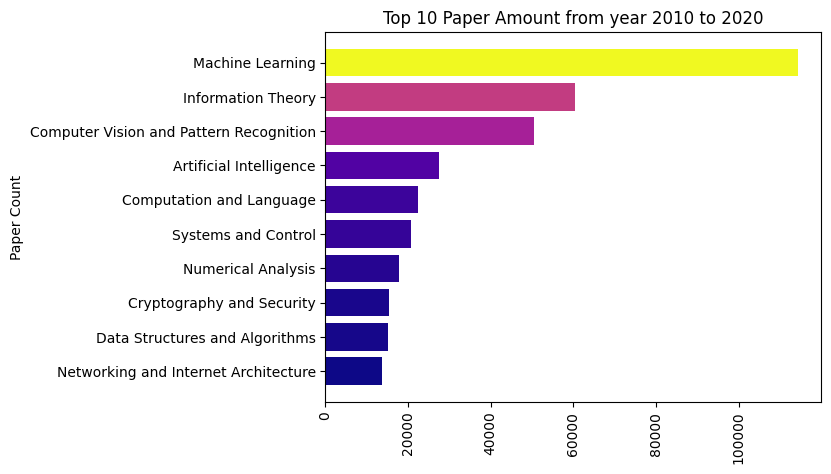

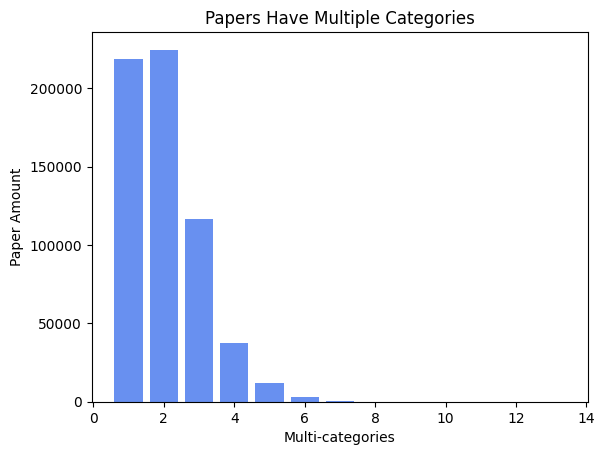

In [32]:

if FAST_RUN_WITH_EXISTING_DATA:
    data_df = pd.read_csv("model_data/data_df.csv", dtype={"id":object})
else:
    # concatenate data_df with df_categories and df_taxonomy to involve more info about the paper
    df_paper =  pd.read_csv("data/arxiv-cs-papers-normalized.csv", dtype={"id":object})
    print("total records of df_paper:",df_paper.shape)
    data_df = kmeans_classify.further_process_data(df_paper, remove_stop_words = True)

# Show the multi-category issue
concatenate_data = data_df.merge(df_categories, how = "left", on="id")
concatenate_data = concatenate_data.merge(df_taxonomy, how='left', on='category_id')
top_categories = kmeans_classify.view_top_category_paper_amount(concatenate_data, 10, 2010, 2020)

## Text Document Clustering ##

Cluster documents using K-means algorithm:
1. Convert words into vectors by using word2vec.
2. Convert each doc into a vector by averaging all the word vectors in the doc.
3. Use k-means clustering to perform unsupervised clustering of the documents.
4. Check clustering quality by using metrics such as homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score and silhouette_score

In [5]:

if FAST_RUN_WITH_EXISTING_DATA:

    if USE_TFIDF:
        tfidf_vectorizer = kmeans_classify.load_from_pickle("model_data/tfidf_vectorizer.pkl")
        tfidf_km = kmeans_classify.load_from_pickle("model_data/tfidf_km_model.pkl")

    elif NORMALIZE_VECTOR:
        print("Choose to use existing models from folder `model_data`, and use normalized word vectors.")
        word_vectorizer = kmeans_classify.load_from_pickle("model_data/norm_word2vec_model.pkl")
        vectorized_docs = kmeans_classify.load_from_pickle("model_data/norm_vectorized_doc.pkl")
        km_model = kmeans_classify.load_from_pickle("model_data/norm_km_model.pkl")
        # kmeans_classify.check_kmean_efficiency(km_model, data_df, vectorized_docs)
    else:
        print("Choose to use existing models from folder `model_data`, and use raw(un-normalized) word vectors.")
        word_vectorizer = kmeans_classify.load_from_pickle("model_data/word2vec_model.pkl")
        vectorized_docs = kmeans_classify.load_from_pickle("model_data/vectorized_doc.pkl")
        km_model = kmeans_classify.load_from_pickle("model_data/km_model.pkl")
        # kmeans_classify.check_kmean_efficiency(km_model, data_df, vectorized_docs)
else:
    ##### only need to create once / or update those models when necessary. Most of conditions, we only need to load the existing models from pickle files. Once running, the pickle files got updated automatically with the new model data.
    # train both raw word2vec and normalized word2vec and tfidf vectorizer. Save to different pickle files

    word_vectorizer, vectorized_docs = kmeans_classify.generate_word_and_doc_vectors(data_df)       # 30+ mins.
    km_model = kmeans_classify.fit_kmean_model(25, vectorized_docs) #17 mins.

    word_vectorizer, vectorized_docs = kmeans_classify.normalize_word2vec_model(data_df, word_vectorizer)    # 20 mins.
    km_model = kmeans_classify.fit_kmean_model(25, vectorized_docs, normalize = True)   # 17 mins.
    
    tfidf_vectorizer, tfidf_doc_vectors, tfidf_tokens  = kmeans_classify.generate_tfidf_vectors(data_df)
    tfidf_km_model = kmeans_classify.fit_kmean_model_tfidf(25, vectorized_docs)   # 17 mins.


### Recommend papers by responding to user query

There are two choices to recommend papers.
First choice: choose by comparing keywords of each doc with user input. However, this method is more accurate but time-consuming. It does not use the pre-training result of KMeans.

Second choice: choose by comparing the user query's doc distance to the cluster_centers. This project will use this method. Kmean model's predict method accepts the user query's doc ventor as input, and predict the closest cluster the doc belongs to.

### 1. Use Word2Vec in KMeans Model ###

In [34]:
# If you want to know each cluster's keywords, top cited papers, generate word cloud for top keywords, call this method

if USE_TFIDF is False:
    print("The current parameter uses Tf-idf vectorization. The code here aborted")
    for i in range(3, 6):
        kmeans_classify.report_cluster_info(i, word_vectorizer, km_model, data_df, df_citations, vectorized_docs)
    

this input is closest to this cluster 5

-------------------------------------------
Top 5 papers closest to the center of Cluster 5
           id                                              title
0  1501.07315  Per-Block-Convex Data Modeling by Accelerated ...
1  2207.08540  Multi-block-Single-probe Variance Reduced Esti...
2  2111.01040  STORM+: Fully Adaptive SGD with Momentum for N...
3   1401.0852  Concave Penalized Estimation of Sparse Gaussia...
4   1406.6603  A scaled gradient projection method for Bayesi...
Top 10 keywords closest to the center of Cluster 5
['leastsquares', 'convex', 'approximate', 'approximation', 'linear', 'stochastic', 'primal', 'primaldual', 'datadependent', 'deterministic']

Cluster 5's top 10 most cited papers:
           id                                              title
0   1009.5055  The Augmented Lagrange Multiplier Method for E...
1   1012.2599  A Tutorial on Bayesian Optimization of Expensi...
2   1211.5063  On the difficulty of training Recurr

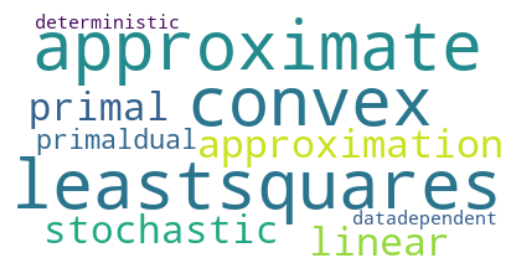

In [7]:
# get user input vector
if USE_TFIDF is False:
    print("The current parameter uses Tf-idf vectorization. The code here aborted")
    user_input = "deep learning algorithm optimization"
    kmeans_classify.predict_user_query_cluster(user_input, word_vectorizer, km_model, data_df, df_citations, vectorized_docs)



### 2. Use Tf-idf in KMeans Model ###


Cluster 10's top 10 most cited papers:
           id                                              title
0   1009.5055  The Augmented Lagrange Multiplier Method for E...
1   1012.2599  A Tutorial on Bayesian Optimization of Expensi...
2   1211.5063  On the difficulty of training Recurrent Neural...
3   1212.5701         ADADELTA: An Adaptive Learning Rate Method
4   1308.3432  Estimating or Propagating Gradients Through St...
5   1412.6980         Adam: A Method for Stochastic Optimization
6  1509.02971  Continuous control with deep reinforcement lea...
7  1606.04838  Optimization Methods for Large-Scale Machine L...
8  1609.04836  On Large-Batch Training for Deep Learning: Gen...
9  1701.07875                                    Wasserstein GAN
Cluster 10's top 20 keywords: ['algorithm', 'problem', 'algorithms', 'optimization', 'problems', 'eqn_latex', 'gradient', 'optimal', 'time', 'stochastic', 'convergence', 'method', 'show', 'linear', 'proposed', 'function', 'number', 'solution', '

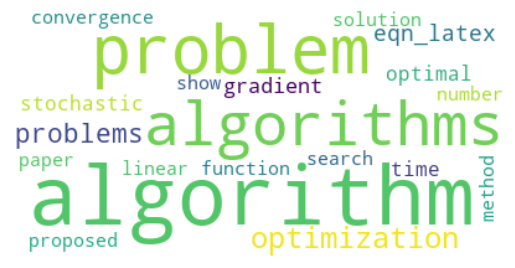


Cluster 11's top 10 most cited papers:
           id                                              title
0   1312.6229  OverFeat: Integrated Recognition, Localization...
1   1405.0312          Microsoft COCO: Common Objects in Context
2   1409.0575  ImageNet Large Scale Visual Recognition Challenge
3  1502.03044  Show, Attend and Tell: Neural Image Caption Ge...
4  1506.01497  Faster R-CNN: Towards Real-Time Object Detecti...
5  1512.03385       Deep Residual Learning for Image Recognition
6  1604.07316          End to End Learning for Self-Driving Cars
7  1612.08242                 YOLO9000: Better, Faster, Stronger
8  1703.06870                                         Mask R-CNN
9  1707.01083  ShuffleNet: An Extremely Efficient Convolution...
Cluster 11's top 20 keywords: ['detection', 'object', 'object detection', 'anomaly', 'anomaly detection', 'data', 'dataset', 'network', 'methods', 'performance', 'method', 'proposed', 'model', 'learning', 'features', 'images', 'feature', 'datase

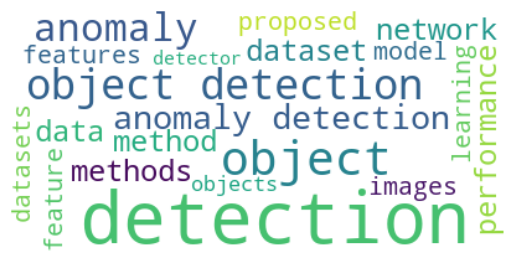


Cluster 12's top 10 most cited papers:
               id                                              title
0       1209.5145  Julia: A Fast Dynamic Language for Technical C...
1       1411.1607     Julia: A Fresh Approach to Numerical Computing
2      1504.00325  Microsoft COCO Captions: Data Collection and E...
3      1603.04467  TensorFlow: Large-Scale Machine Learning on He...
4      1605.07683           Learning End-to-End Goal-Oriented Dialog
5      1606.06565                     Concrete Problems in AI Safety
6      1612.03801                                       DeepMind Lab
7      1806.01261  Relational inductive biases, deep learning, an...
8      cs/0004015  Introduction to the GiNaC Framework for Symbol...
9  hep-ph/0702279                  The Multithreaded version of FORM
Cluster 12's top 20 keywords: ['system', 'systems', 'software', 'research', 'users', 'security', 'paper', 'user', 'design', 'development', 'data', 'information', 'applications', 'intelligence', 'use', 

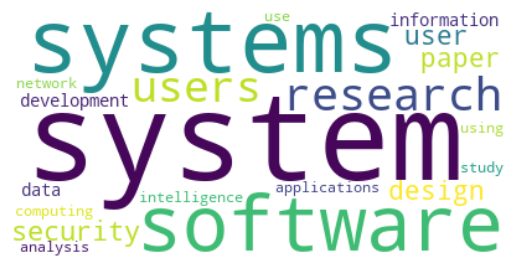


Cluster 13's top 10 most cited papers:
           id                                              title
0   0906.0612                      Community detection in graphs
1   1111.4503           The Anatomy of the Facebook Social Graph
2  1608.04511  AntPaP: Patrolling and Fair Partitioning of Gr...
3  1609.02907  Semi-Supervised Classification with Graph Conv...
4  1611.00712  The Concrete Distribution: A Continuous Relaxa...
5  1701.03980          DyNet: The Dynamic Neural Network Toolkit
6  1703.06103  Modeling Relational Data with Graph Convolutio...
7  1705.02801  Graph Embedding Techniques, Applications, and ...
8  1709.05584  Representation Learning on Graphs: Methods and...
9  1710.10903                           Graph Attention Networks
Cluster 13's top 20 keywords: ['graph', 'graphs', 'graph neural', 'networks', 'neural', 'node', 'neural networks', 'nodes', 'network', 'edges', 'knowledge', 'problem', 'learning', 'vertices', 'model', 'data', 'knowledge graph', 'eqn_latex', 'str

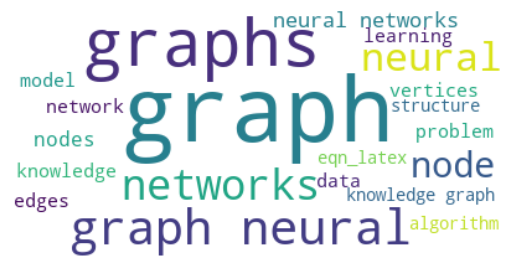


Cluster 14's top 10 most cited papers:
           id                                              title
0   1412.5567  Deep Speech: Scaling up end-to-end speech reco...
1  1508.01211                           Listen, Attend and Spell
2  1609.03193  Wav2Letter: an End-to-End ConvNet-based Speech...
3  1610.05256  Achieving Human Parity in Conversational Speec...
4  1610.09975  Neural Speech Recognizer: Acoustic-to-Word LST...
5  1703.10135      Tacotron: Towards End-to-End Speech Synthesis
6  1706.05137                        One Model To Learn Them All
7  1711.10433  Parallel WaveNet: Fast High-Fidelity Speech Sy...
8  1712.01769  State-of-the-art Speech Recognition With Seque...
9  1712.05884  Natural TTS Synthesis by Conditioning WaveNet ...
Cluster 14's top 20 keywords: ['speech', 'speech recognition', 'recognition', 'automatic speech', 'speaker', 'automatic', 'model', 'models', 'acoustic', 'audio', 'language', 'voice', 'training', 'data', 'speakers', 'system', 'enhancement', 'emot

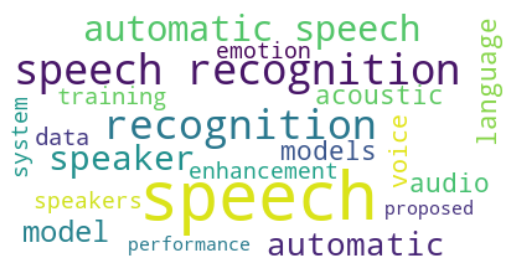

In [18]:
# randomly choose some clusters to check the keywords and top cited papers in the clusters
if USE_TFIDF:
    for i in range(10, 15):
        kmeans_classify.report_cluster_info_tfidf(i, tfidf_vectorizer, tfidf_km, data_df, df_citations)
else:
    print("The current parameter uses word2vec vectorization. The code here aborted.")

this input is closest to this cluster 10

Cluster 10's top 10 most cited papers:
           id                                              title
0   1009.5055  The Augmented Lagrange Multiplier Method for E...
1   1012.2599  A Tutorial on Bayesian Optimization of Expensi...
2   1211.5063  On the difficulty of training Recurrent Neural...
3   1212.5701         ADADELTA: An Adaptive Learning Rate Method
4   1308.3432  Estimating or Propagating Gradients Through St...
5   1412.6980         Adam: A Method for Stochastic Optimization
6  1509.02971  Continuous control with deep reinforcement lea...
7  1606.04838  Optimization Methods for Large-Scale Machine L...
8  1609.04836  On Large-Batch Training for Deep Learning: Gen...
9  1701.07875                                    Wasserstein GAN
Cluster 10's top 20 keywords: ['algorithm', 'problem', 'algorithms', 'optimization', 'problems', 'eqn_latex', 'gradient', 'optimal', 'time', 'stochastic', 'convergence', 'method', 'show', 'linear', 'propo

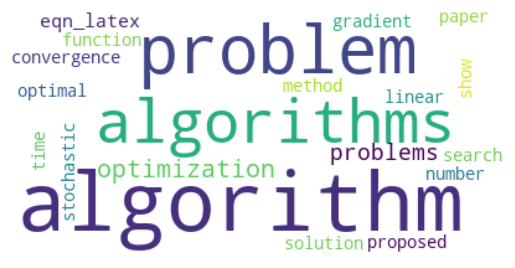

In [35]:
if USE_TFIDF:
    # get user input vector
    user_input = "deep learning algorithm optimization"
    kmeans_classify.predict_user_query_cluster_tfidf(user_input, tfidf_vectorizer, tfidf_km, data_df, df_citations)
else:
    print("The current parameter uses word2vec vectorization. The code here aborted.")